# ARIMAX Time Series Forecasting for P.1078, PVC Price (China)

This notebook preprocesses historical pricing data, selects features using ElasticNet, creates lag variables, checks for stationarity, and trains an ARIMAX model to forecast the P.1078 feature N months ahead.

### ARIMAX Model Overview

**ARIMAX (AutoRegressive Integrated Moving Average with eXogenous variables)** is a time-series forecasting model that extends ARIMA by including additional explanatory variables (exogenous features) that may help improve prediction accuracy.

The model combines three main components:

1. **AR (AutoRegressive part)**  
   Uses past values of the time series to predict the current value.

2. **I (Integrated part)**  
   Applies differencing to make the time series stationary (removes trend/seasonality).

3. **MA (Moving Average part)**  
   Uses past forecast errors (residuals) to model the current value.

4. **X (Exogenous variables)**  
   External features (e.g., related commodity prices, macroeconomic indicators) that are believed to influence the target series.

---

### Hyperparameters

- **p (AR order):** Number of lag observations of the target series included in the model.  
- **d (Differencing order):** Number of times the series is differenced to achieve stationarity.  
- **q (MA order):** Number of lagged forecast errors included.  
- **exog:** The external variables provided to the model (must align in time with the series).  
- **trend:** Type of trend component to include (`'n'` = none, `'c'` = constant, `'t'` = linear trend, `'ct'` = constant + trend).  
- **seasonal_order (P, D, Q, m):** (Optional) If using SARIMAX extension, specifies seasonal ARIMA terms where:
  - **P** = seasonal AR order  
  - **D** = seasonal differencing  
  - **Q** = seasonal MA order  
  - **m** = seasonality period (e.g., 12 for monthly data with yearly seasonality)  

---

**Key Idea:**  
ARIMAX captures the internal structure of the time series (via AR, I, MA terms) while leveraging external signals (`exog`) to improve forecasting performance.


In [83]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

# 1. Setting target PVC price to be forecasted and importing dataset

Set `target` variable here to be the desired target forecast variable (eg. PVC price, Raw material price etc.)

In [84]:
target = 'P.1078'  # Change to your target column

# Load the new CSV file with year and month columns
# This file is assumed to have columns: year, month, and all features (including P.1080)
df = pd.read_csv('price_data_with_PMI.csv')

# Drop rows where any value is '-'
df = df[~df.isin(['-']).any(axis=1)]

# Drop rows with any NaN values
df = df.dropna()

# Normalize all columns except 'month' and 'year'
cols_to_normalize = [col for col in df.columns if col not in ['month', 'year']]
scaler = MinMaxScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

df.head()

,year,month,OMD.1016,P.1035.1027,P.1080,OMD.1002,P.1036.1029,P.1081,L3.2a,L3.5,...,Use of Sub-Contractors_France,Use of Sub-Contractors_France.1,Use of Sub-Contractors_United Kingdom.1,Use of Sub-Contractors_Italy.2,Use of Sub-Contractors_United Kingdom.2,Use of Sub-Contractors_France.2,Use of Sub-Contractors_Europe,Use of Sub-Contractors_Ireland.2,Use of Sub-Contractors_Germany.2,Use of Sub-Contractors_Eurozone.1
0,2020,3,0.035616,0.060412,0.179899,0.126296,0.208719,0.144481,0.066953,0.070707,...,0.632017,0.670213,0.642202,0.231651,0.654206,0.670213,0.547684,0.630137,0.670968,0.455526
1,2020,4,0.027397,0.000000,0.004054,0.000000,0.039971,0.062662,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506452,0.000000
2,2020,5,0.028767,0.055052,0.000000,0.099192,0.000000,0.000000,0.016511,0.017172,...,0.436590,0.451064,0.344037,0.878440,0.348131,0.451064,0.482289,0.257991,0.764516,0.506739
3,2020,6,0.010959,0.078969,0.062500,0.204660,0.135397,0.050325,0.060712,0.064646,...,0.800416,0.776596,0.745413,0.788991,0.703271,0.776596,0.716621,0.824201,0.638710,0.638814
4,2020,7,0.027397,0.145773,0.098649,0.235854,0.220006,0.104870,0.052912,0.056566,...,0.783784,0.787234,0.676606,0.777523,0.698598,0.787234,0.760218,0.753425,0.938710,0.733154


## 2. Feature Selection and Model Order Identification

### Autocorrelation, ACF, and PACF

**Autocorrelation (Serial Correlation):**  
Measures how a time series is related to its past values.  
- Example: If today’s temperature is similar to yesterday’s, the series is autocorrelated.  

---

### Autocorrelation Function (ACF)
- Plots correlation of the series with its lagged values.  
- **Lag 1:** correlation between `t` and `t−1`  
- **Lag 2:** correlation between `t` and `t−2`, etc.  

**How to Read ACF:**
- **Significant lag:** bar beyond confidence bounds → strong autocorrelation.  
- **Gradual decline:** indicates long-term dependency.  
- **Regular spikes:** suggests seasonality.  

---

### Partial Autocorrelation (PACF)
- Measures correlation between two points **while controlling for shorter lags**.  
- Shows the *direct* relationship at a given lag.  

**How to Read PACF:**
- **Significant spike at lag k:** include that lag in AR model.  
- **Cut-off point:** lag where PACF cuts off → order of AR(p).  

---

We will use autocorrelation analysis (ACF, PACF), information criteria (AIC, BIC), and automated grid search to select the best ARIMA/ARIMAX model. Exogenous features will be selected using correlation analysis and ElasticNet.

### Interpreting ACF & PACF Results

- **ACF:** Significant correlations up to lag 5, then gradually taper off.  
  → Suggests the presence of a **MA component**, but not a sharp cutoff (more gradual decay).  

- **PACF:** Strong spikes at lags 1 and 2, then quickly drop off.  
  → Suggests an **AR(2) process** (p = 2).  

---

### Inference
- **p (AR order):** 2 (from PACF cutoff at lag 2).  
- **q (MA order):** Could be small (0–1) since ACF decays rather than sharply cutting off.  
- **d (Differencing order):** Determined separately by checking stationarity (ADF/KPSS tests).  

**Possible starting models:**  
- ARIMA(2, d, 0)  
- ARIMA(2, d, 1)  


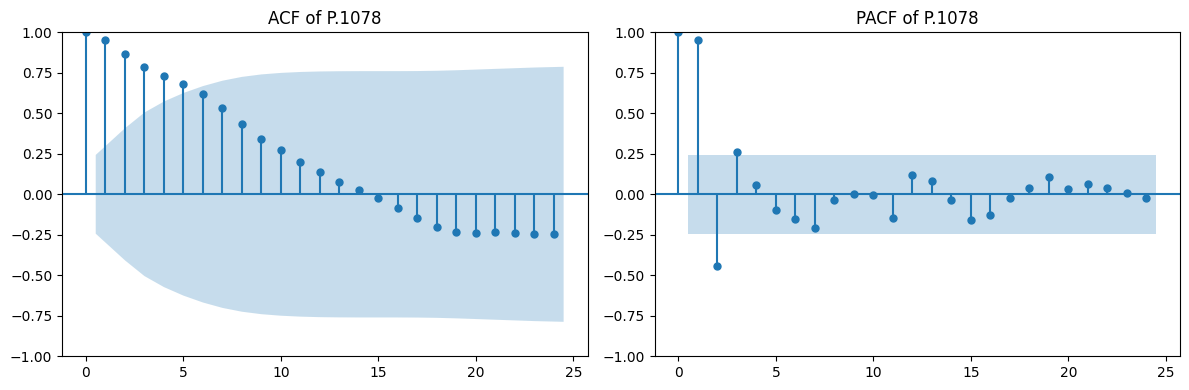

Top correlated features: ['P.1079', 'P.1089', 'P.1080', 'P.1091', 'P.1077']
ElasticNet-selected features: ['P.1079', 'P.1089', 'P.1057', 'G.1004']
Exogenous features for ARIMAX: ['P.1080', 'P.1091', 'P.1077', 'P.1057', 'P.1079', 'G.1004', 'P.1089']


In [85]:
# Set number of features (from elasticnet feature selection) and exogenous variables to be used in training
N_features = 4
N_exog = 5

# --- Autocorrelation Analysis ---

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(df[target], lags=24, ax=plt.gca())
plt.title('ACF of P.1078')
plt.subplot(1, 2, 2)
plot_pacf(df[target], lags=24, ax=plt.gca(), method='ywm')
plt.title('PACF of P.1078')
plt.tight_layout()
plt.show()

# --- Correlation Analysis for Exogenous Features ---
correlations = df.corr()[target].drop([target, 'month', 'year'])
exog_candidates = correlations.abs().sort_values(ascending=False).head(N_exog).index.tolist()
print('Top correlated features:', exog_candidates)

# --- ElasticNet Feature Selection ---
feature_cols = [col for col in df.columns if col not in [target, 'month', 'year']]
X = df[feature_cols]
y = df[target]
enet = ElasticNetCV(cv=5, random_state=0)
enet.fit(X, y)
feature_importance = pd.Series(np.abs(enet.coef_), index=feature_cols)
selected_exog = feature_importance.sort_values(ascending=False).head(N_features).index.tolist()
print('ElasticNet-selected features:', selected_exog)

# Final exogenous features (union of correlation and ElasticNet)
exog_features = list(set(exog_candidates + selected_exog))
print('Exogenous features for ARIMAX:', exog_features)

## 3. Stationarity Check: Augmented Dickey-Fuller (ADF) Test

We will difference the target variable until it is stationary. The number of differences will be used as the `d` parameter in ARIMAX. Here we find that `d` = 1.

In [86]:
# Function to difference until stationary
def make_stationary(series, max_diff=5, significance=0.05):
    d = 0
    pval = 1
    diffed = series.copy()
    while pval > significance and d < max_diff:
        adf_result = adfuller(diffed)
        pval = adf_result[1]
        if pval > significance:
            diffed = diffed.diff().dropna()
            d += 1
    return d, diffed

d, stationary_series = make_stationary(df[target])
print(f"Number of differences required for stationarity: {d}")

Number of differences required for stationarity: 1


## 5. Train-Test Split

We will split the data into train and test sets for time series forecasting. 
---

Here the `test_size` determines the forecast duration desired. In this case we desire to forecast 12 months ahead.

In [87]:
# Train-test split (last 12 months as test set)
test_size = 12
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]
# Prepare exogenous variables for train and test sets
exog_train = train[exog_features]
exog_test = test[exog_features]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (53, 316)
Test shape: (12, 316)


## 6. Baseline ARIMAX(1,1,1) Model

Train a baseline ARIMAX model and visualize predictions.

✓ Train predictions: 53 points
✓ Test predictions: 12 points
Train prediction range: [0.0082, 0.9941]
Test prediction range: [0.0247, 0.0940]
Train (Unnormalized) - RMSE: 16.5218, MAE: 12.1865
Test (Unnormalized) - RMSE: 8.4868, MAE: 7.0531


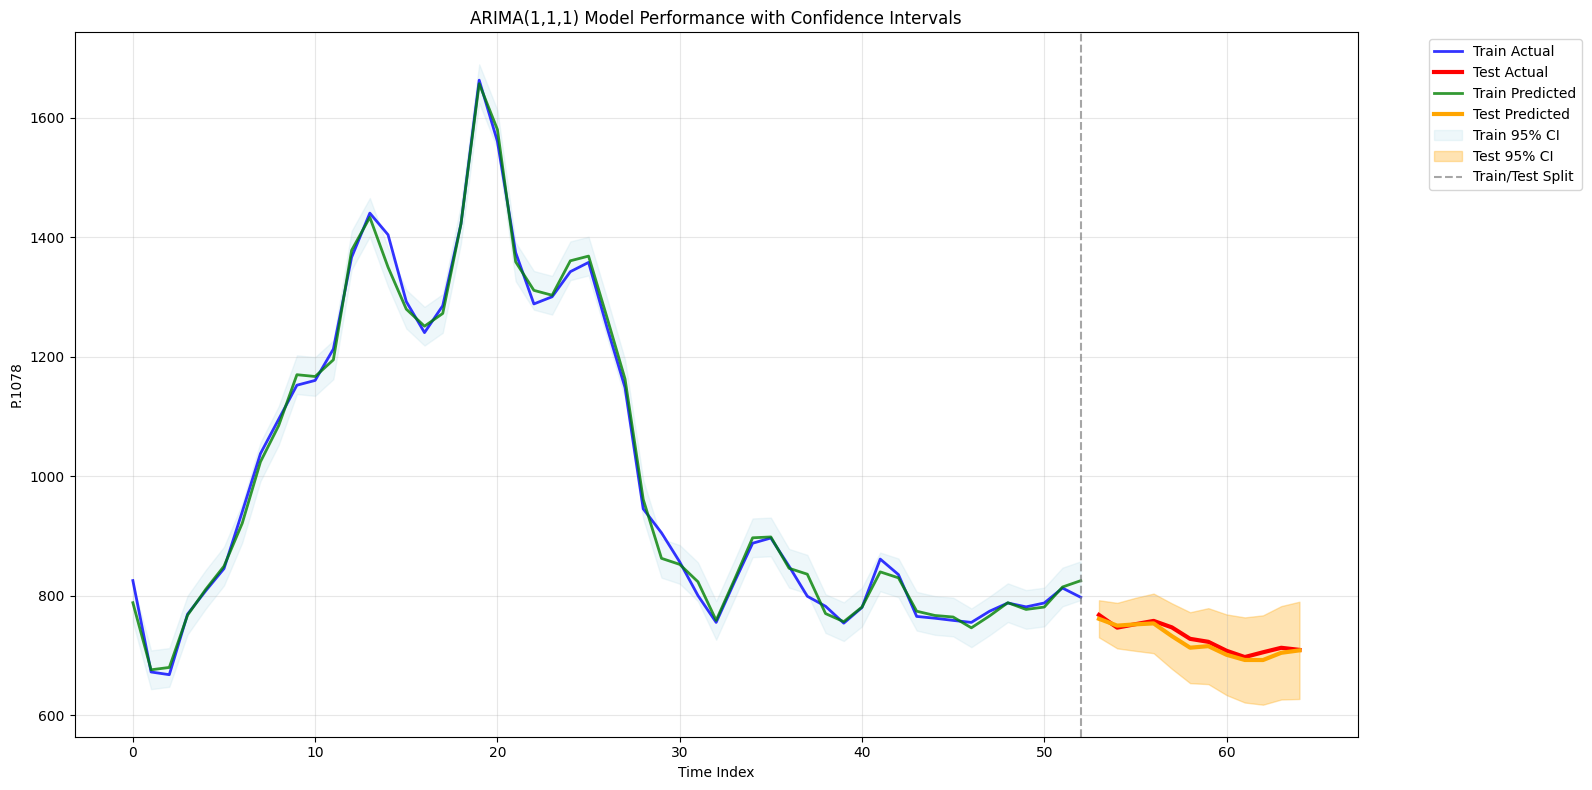


Confidence Interval Analysis:
Train CI Average Width: 0.0651
Test CI Average Width: 0.1196
Train Coverage: 92.5%
Test Coverage: 100.0%


In [88]:
import random

# Fit ARIMA(1,d,1) on training set
arima_order = (1, d, 1)
# ARIMAX (1,d,1) model with exogenous variables
model = ARIMA(train[target], order=arima_order, exog=exog_train)
model_fit = model.fit()

# MOST RELIABLE APPROACH - Use fitted values for training
train_pred = model_fit.fittedvalues  # In-sample fitted values
train_residual_std = np.std(model_fit.resid)
train_margin = 1.96 * train_residual_std  # 95% CI

# Create training confidence intervals
train_conf_int = pd.DataFrame({
    f'lower {target}': train_pred - train_margin,
    f'upper {target}': train_pred + train_margin
}, index=train_pred.index)

# ARIMAX forecast with exogenous variables
forecast_result = model_fit.get_forecast(steps=test_size, exog=exog_test)
test_pred = forecast_result.predicted_mean
test_conf_int = forecast_result.conf_int()

print(f"✓ Train predictions: {len(train_pred)} points")
print(f"✓ Test predictions: {len(test_pred)} points")
print(f"Train prediction range: [{train_pred.min():.4f}, {train_pred.max():.4f}]")
print(f"Test prediction range: [{test_pred.min():.4f}, {test_pred.max():.4f}]")

def inverse_transform_series(series, scaler, cols_to_normalize, target):
    temp = pd.DataFrame(0, index=range(len(series)), columns=cols_to_normalize)
    temp[target] = series.values if hasattr(series, 'values') else series
    temp_inv = scaler.inverse_transform(temp)
    target_idx = cols_to_normalize.index(target)
    return temp_inv[:, target_idx]

# For train_conf_int and test_conf_int DataFrames
def inverse_transform_ci(ci_df, df, scaler, target):
    lower = inverse_transform_series(ci_df.iloc[:, 0], df, scaler, target)
    upper = inverse_transform_series(ci_df.iloc[:, 1], df, scaler, target)
    return lower, upper

train_actual_unnorm = inverse_transform_series(train[target], scaler, cols_to_normalize, target)
train_pred_unnorm   = inverse_transform_series(train_pred, scaler, cols_to_normalize, target)
test_actual_unnorm  = inverse_transform_series(test[target], scaler, cols_to_normalize, target)
test_pred_unnorm    = inverse_transform_series(test_pred, scaler, cols_to_normalize, target)

train_lower_unnorm = inverse_transform_series(train_conf_int.iloc[:, 0], scaler, cols_to_normalize, target)
train_upper_unnorm = inverse_transform_series(train_conf_int.iloc[:, 1], scaler, cols_to_normalize, target)
test_lower_unnorm  = inverse_transform_series(test_conf_int.iloc[:, 0], scaler, cols_to_normalize, target)
test_upper_unnorm  = inverse_transform_series(test_conf_int.iloc[:, 1], scaler, cols_to_normalize, target)

from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics(actual, predicted, name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae

train_rmse_unnorm, train_mae_unnorm = calculate_metrics(train_actual_unnorm, train_pred_unnorm, "Train (Unnormalized)")
test_rmse_unnorm, test_mae_unnorm   = calculate_metrics(test_actual_unnorm, test_pred_unnorm, "Test (Unnormalized)")

# Enhanced visualization with confidence intervals
plt.figure(figsize=(16, 8))

plt.plot(train.index, train_actual_unnorm, label='Train Actual', color='blue', alpha=0.8, linewidth=2)
plt.plot(test.index, test_actual_unnorm, label='Test Actual', color='red', linewidth=3)
plt.plot(train.index, train_pred_unnorm, label='Train Predicted', color='green', alpha=0.8, linewidth=2)
plt.plot(test.index, test_pred_unnorm, label='Test Predicted', color='orange', linewidth=3)
plt.fill_between(train.index, train_lower_unnorm, train_upper_unnorm, alpha=0.2, color='lightblue', label='Train 95% CI')
plt.fill_between(test.index, test_lower_unnorm, test_upper_unnorm, alpha=0.3, color='orange', label='Test 95% CI')

# Add vertical line separating train/test
plt.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7, 
            label='Train/Test Split')

plt.title(f'ARIMA(1,{d},1) Model Performance with Confidence Intervals')
plt.xlabel('Time Index')
plt.ylabel(target)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print confidence interval statistics
print(f"\nConfidence Interval Analysis:")
print(f"Train CI Average Width: {(train_conf_int.iloc[:, 1] - train_conf_int.iloc[:, 0]).mean():.4f}")
print(f"Test CI Average Width: {(test_conf_int.iloc[:, 1] - test_conf_int.iloc[:, 0]).mean():.4f}")

# Coverage analysis
train_coverage = ((train[target] >= train_conf_int.iloc[:, 0]) & 
                 (train[target] <= train_conf_int.iloc[:, 1])).mean() * 100
test_coverage = ((test[target] >= test_conf_int.iloc[:, 0]) & 
                (test[target] <= test_conf_int.iloc[:, 1])).mean() * 100

print(f"Train Coverage: {train_coverage:.1f}%")
print(f"Test Coverage: {test_coverage:.1f}%")

## 7. Hyperparameter Tuning for ARIMAX

We will tune the (p,d,q) parameters using grid search and select the best model based on AIC.

---

This is the process that will take the longest due to the need to evaluate the whole grid of `p` and `q` variables.

In [89]:
import itertools

# Define parameter grid
p = q = range(0, 5)  # Adjust range as needed
pdq = list(itertools.product(p, [d], q))

# Add progress indicator after line 5:
print(f"Testing {len(pdq)} parameter combinations...")

best_aic = np.inf
best_order = None
best_model = None

# Add better error handling in the loop:
for i, order in enumerate(pdq):
    if i % 10 == 0:  # Progress update every 10 iterations
        print(f"Progress: {i}/{len(pdq)}")
    try:
        model = ARIMA(train[target], order=order, exog=exog_train)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        # Optionally print errors for debugging
        # print(f"Error with order {order}: {e}")
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

Testing 25 parameter combinations...
Progress: 0/25
Progress: 10/25
Progress: 20/25
Best ARIMA order: (0, 1, 1) with AIC: -265.00606768879385


## 8. Visualize Tuned ARIMAX Model

Visualize the performance of the best ARIMA model on train and test sets.

✓ Train fitted values: 53 points
✓ Test forecasts: 12 points
✓ Train CI shape: (53, 2)
✓ Test CI shape: (12, 2)


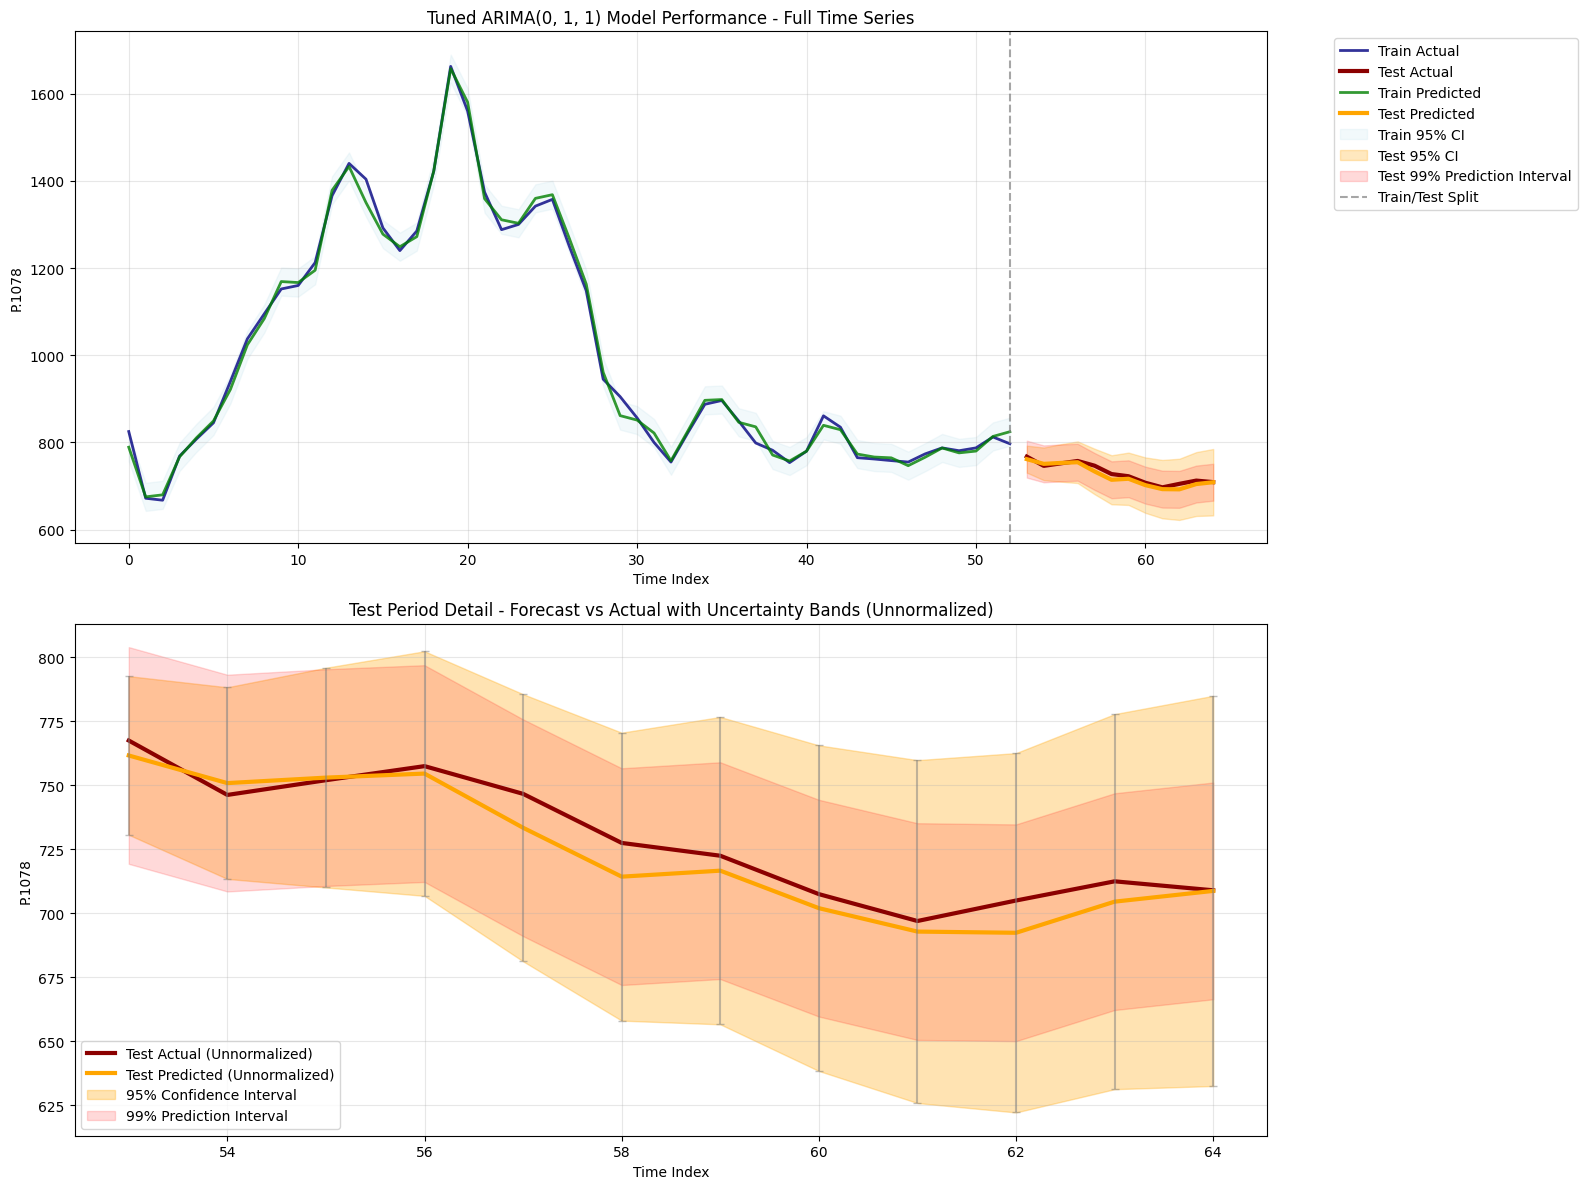

Train (Tuned, Unnormalized) - RMSE: 16.4349, MAE: 12.1445
Test (Tuned, Unnormalized) - RMSE: 7.7299, MAE: 6.4198

CONFIDENCE INTERVAL ANALYSIS
Train CI Average Width: 0.0647
Test CI Average Width:  0.1135
CI Width Increase:      +75.4%

Coverage Analysis (should be ~95% for good calibration):
Train Coverage: 92.5%
Test Coverage:  100.0%

Forecast Uncertainty Metrics:
Average forecast error: 0.0065
Max CI width in test:   0.1532
Min CI width in test:   0.0623

✓ All test points fall within 95% confidence intervals!


In [90]:
# MOST RELIABLE APPROACH FOR TUNED MODEL

# Get forecast with confidence intervals for test period
forecast_result = best_model.get_forecast(steps=test_size, exog=exog_test)
test_pred_best = forecast_result.predicted_mean
test_conf_int_best = forecast_result.conf_int()

# Get training predictions using fitted values
train_pred_best = best_model.fittedvalues  # In-sample fitted values
train_residual_std = np.std(best_model.resid)
train_margin = 1.96 * train_residual_std  # 95% CI

# Create training confidence intervals
train_conf_int_best = pd.DataFrame({
    f'lower {target}': train_pred_best - train_margin,
    f'upper {target}': train_pred_best + train_margin
}, index=train_pred_best.index)

print(f"✓ Train fitted values: {len(train_pred_best)} points")
print(f"✓ Test forecasts: {len(test_pred_best)} points")
print(f"✓ Train CI shape: {train_conf_int_best.shape}")
print(f"✓ Test CI shape: {test_conf_int_best.shape}")

# Add prediction intervals (wider than confidence intervals)
pred_std = np.std(best_model.resid)
prediction_margin = 2.576 * pred_std  # 99% prediction interval

# Unnormalize actuals and predictions
train_actual_unnorm = inverse_transform_series(train[target], scaler, cols_to_normalize, target)
train_pred_unnorm   = inverse_transform_series(train_pred_best, scaler, cols_to_normalize, target)
test_actual_unnorm  = inverse_transform_series(test[target], scaler, cols_to_normalize, target)
test_pred_unnorm    = inverse_transform_series(test_pred_best, scaler, cols_to_normalize, target)

# Unnormalize confidence intervals
train_lower_unnorm = inverse_transform_series(train_conf_int_best.iloc[:, 0], scaler, cols_to_normalize, target)
train_upper_unnorm = inverse_transform_series(train_conf_int_best.iloc[:, 1], scaler, cols_to_normalize, target)
test_lower_unnorm  = inverse_transform_series(test_conf_int_best.iloc[:, 0], scaler, cols_to_normalize, target)
test_upper_unnorm  = inverse_transform_series(test_conf_int_best.iloc[:, 1], scaler, cols_to_normalize, target)

# For 99% prediction intervals (unnormalized)
test_pred_upper = test_pred_best + prediction_margin
test_pred_lower = test_pred_best - prediction_margin
test_pred_upper_unnorm = inverse_transform_series(test_pred_upper, scaler, cols_to_normalize, target)
test_pred_lower_unnorm = inverse_transform_series(test_pred_lower, scaler, cols_to_normalize, target)

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
ax1.plot(train.index, train_actual_unnorm, label='Train Actual', color='navy', alpha=0.8, linewidth=2)
ax1.plot(test.index, test_actual_unnorm, label='Test Actual', color='darkred', linewidth=3)
ax1.plot(train.index, train_pred_unnorm, label='Train Predicted', color='green', alpha=0.8, linewidth=2)
ax1.plot(test.index, test_pred_unnorm, label='Test Predicted', color='orange', linewidth=3)
ax1.fill_between(train.index, train_lower_unnorm, train_upper_unnorm, alpha=0.15, color='lightblue', label='Train 95% CI')
ax1.fill_between(test.index, test_lower_unnorm, test_upper_unnorm, alpha=0.25, color='orange', label='Test 95% CI')
ax1.fill_between(test.index, test_pred_lower_unnorm, test_pred_upper_unnorm, alpha=0.15, color='red', label='Test 99% Prediction Interval')
errors_unnorm = np.abs(test_upper_unnorm - test_pred_unnorm)

ax1.axvline(x=train.index[-1], color='gray', linestyle='--', alpha=0.7, 
           label='Train/Test Split')

ax1.set_title(f'Tuned ARIMA{best_order} Model Performance - Full Time Series')
ax1.set_xlabel('Time Index')
ax1.set_ylabel(target)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Zoomed view of test period only
ax2.plot(test.index, test_actual_unnorm, label='Test Actual (Unnormalized)', color='darkred', linewidth=3)
ax2.plot(test.index, test_pred_unnorm, label='Test Predicted (Unnormalized)', color='orange', linewidth=3)
ax2.fill_between(test.index, test_lower_unnorm, test_upper_unnorm, alpha=0.3, color='orange', label='95% Confidence Interval')
ax2.fill_between(test.index, test_pred_lower_unnorm, test_pred_upper_unnorm, alpha=0.15, color='red', label='99% Prediction Interval')
ax2.errorbar(test.index, test_pred_unnorm, yerr=errors_unnorm, fmt='none', ecolor='gray', alpha=0.5, capsize=3)
ax2.set_title('Test Period Detail - Forecast vs Actual with Uncertainty Bands (Unnormalized)')
ax2.set_xlabel('Time Index')
ax2.set_ylabel(target)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced error metrics with confidence interval analysis
train_rmse_best, train_mae_best = calculate_metrics(train_actual_unnorm, train_pred_unnorm, "Train (Tuned, Unnormalized)")
test_rmse_best, test_mae_best = calculate_metrics(test_actual_unnorm, test_pred_unnorm, "Test (Tuned, Unnormalized)")

# Confidence interval analysis
ci_width_train = (train_conf_int_best.iloc[:, 1] - train_conf_int_best.iloc[:, 0]).mean()
ci_width_test = (test_conf_int_best.iloc[:, 1] - test_conf_int_best.iloc[:, 0]).mean()

# Coverage analysis
train_coverage = ((train[target] >= train_conf_int_best.iloc[:, 0]) & 
                 (train[target] <= train_conf_int_best.iloc[:, 1])).mean() * 100
test_coverage = ((test[target] >= test_conf_int_best.iloc[:, 0]) & 
                (test[target] <= test_conf_int_best.iloc[:, 1])).mean() * 100

print(f"\n{'='*50}")
print(f"CONFIDENCE INTERVAL ANALYSIS")
print(f"{'='*50}")
print(f"Train CI Average Width: {ci_width_train:.4f}")
print(f"Test CI Average Width:  {ci_width_test:.4f}")
print(f"CI Width Increase:      {((ci_width_test/ci_width_train-1)*100):+.1f}%")
print(f"\nCoverage Analysis (should be ~95% for good calibration):")
print(f"Train Coverage: {train_coverage:.1f}%")
print(f"Test Coverage:  {test_coverage:.1f}%")

# Forecast uncertainty analysis
print(f"\nForecast Uncertainty Metrics:")
print(f"Average forecast error: {np.mean(np.abs(test[target] - test_pred_best)):.4f}")
print(f"Max CI width in test:   {(test_conf_int_best.iloc[:, 1] - test_conf_int_best.iloc[:, 0]).max():.4f}")
print(f"Min CI width in test:   {(test_conf_int_best.iloc[:, 1] - test_conf_int_best.iloc[:, 0]).min():.4f}")

# Points outside confidence intervals
outside_ci = ~((test[target] >= test_conf_int_best.iloc[:, 0]) & 
               (test[target] <= test_conf_int_best.iloc[:, 1]))
if outside_ci.any():
    print(f"\nPeriods outside 95% CI:")
    for idx in test.index[outside_ci]:
        actual_val = test[target].loc[idx]
        pred_val = test_pred_best.loc[idx]
        ci_lower = test_conf_int_best.loc[idx].iloc[0]
        ci_upper = test_conf_int_best.loc[idx].iloc[1]
        print(f"  {idx}: Actual={actual_val:.4f}, Pred={pred_val:.4f}, CI=[{ci_lower:.4f}, {ci_upper:.4f}]")
else:
    print(f"\n✓ All test points fall within 95% confidence intervals!")

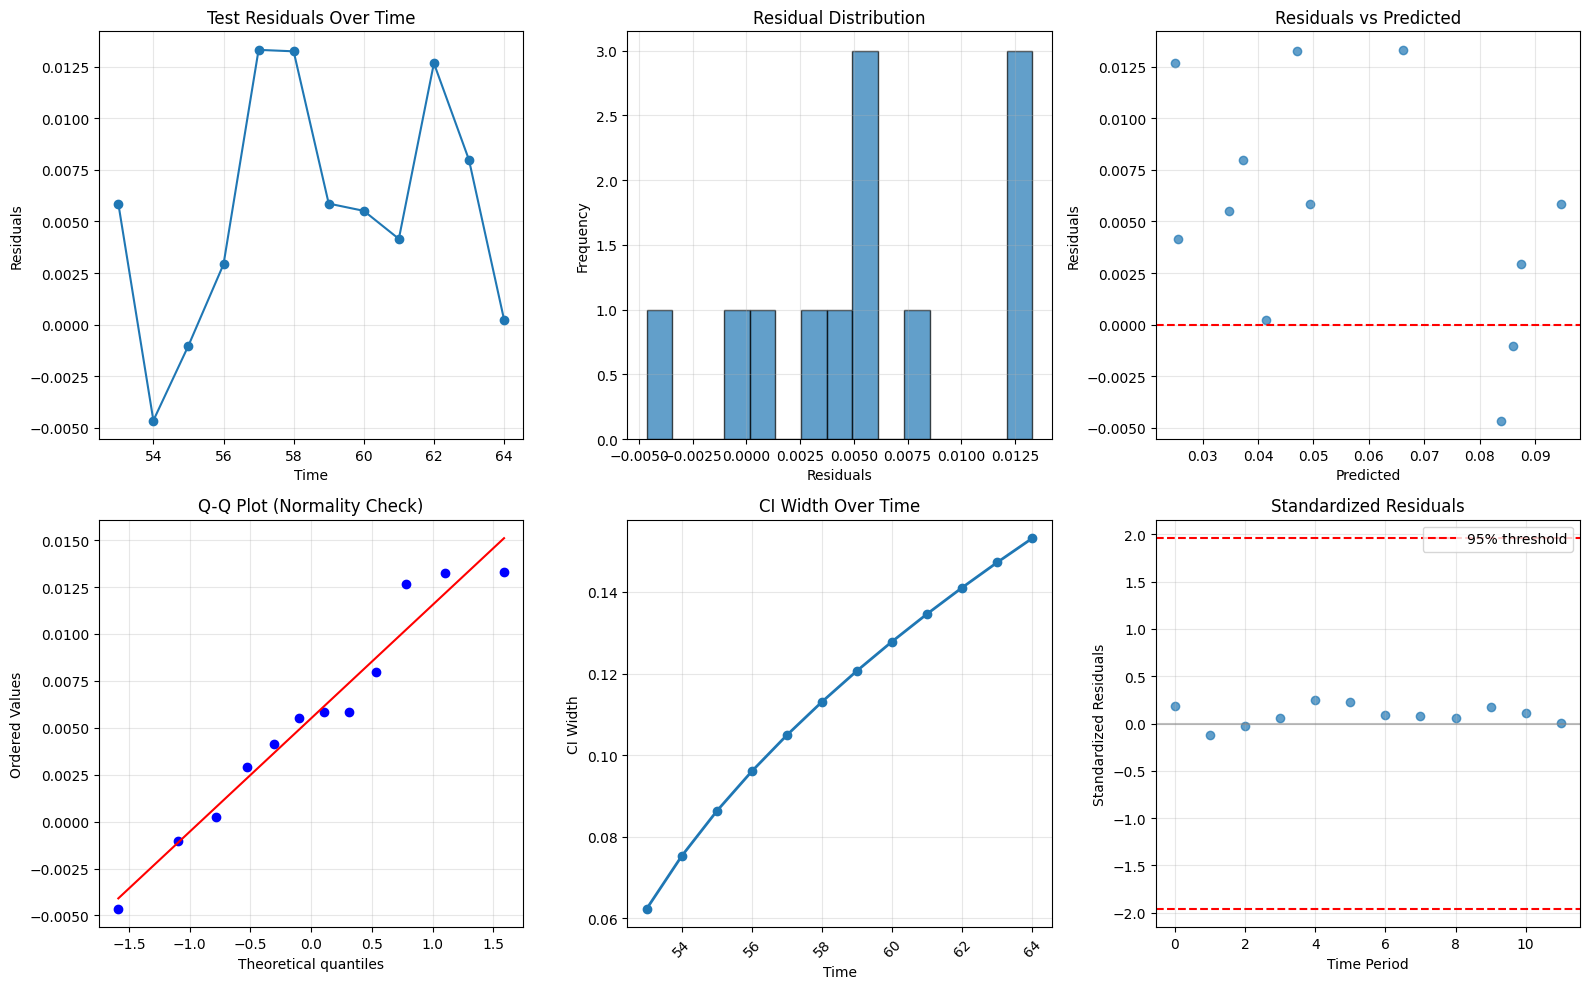

Residual Statistics:
Mean: 0.0055
Std: 0.0057
Min: -0.0046
Max: 0.0133

Confidence Interval Diagnostics:
CI Coverage: 100.0% (target: 95%)
Average CI Width: 0.1135
CI Width Std: 0.0292
Periods outside CI: 0/12 (0.0%)


In [91]:
# Model Diagnostics - RELIABLE VERSION
residuals = test[target] - test_pred_best

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.plot(test.index, residuals, marker='o')
plt.title('Test Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.hist(residuals, bins=15, alpha=0.7, edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.scatter(test_pred_best, residuals, alpha=0.7)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
# Confidence interval width over time
ci_widths = test_conf_int_best.iloc[:, 1] - test_conf_int_best.iloc[:, 0]
plt.plot(test.index, ci_widths, marker='o', linewidth=2, markersize=6)
plt.title('CI Width Over Time')
plt.xlabel('Time')
plt.ylabel('CI Width')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
# Standardized residuals vs CI
standardized_residuals = residuals / (ci_widths / 1.96)  # Normalize by CI width
plt.scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.7)
plt.axhline(y=1.96, color='r', linestyle='--', label='95% threshold')
plt.axhline(y=-1.96, color='r', linestyle='--')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
plt.title('Standardized Residuals')
plt.xlabel('Time Period')
plt.ylabel('Standardized Residuals')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Min: {residuals.min():.4f}")
print(f"Max: {residuals.max():.4f}")

print(f"\nConfidence Interval Diagnostics:")
print(f"CI Coverage: {test_coverage:.1f}% (target: 95%)")
print(f"Average CI Width: {ci_width_test:.4f}")
print(f"CI Width Std: {ci_widths.std():.4f}")
outside_ci_count = (~((test[target] >= test_conf_int_best.iloc[:, 0]) & 
                     (test[target] <= test_conf_int_best.iloc[:, 1]))).sum()
print(f"Periods outside CI: {outside_ci_count}/{len(test)} ({outside_ci_count/len(test)*100:.1f}%)")